# [AHA! Activity Health Analytics](http://casas.wsu.edu/)
[Center for Advanced Studies of Adaptive Systems (CASAS)](http://casas.wsu.edu/)

[Washington State University](https://wsu.edu)

# L3 Activity Density Maps: Part 1

## Learner Objectives
At the conclusion of this lesson, participants should have an understanding of:
* Creating activity density maps

## Acknowledgments
Content used in this lesson is based upon information in the following sources:
* [Wang et al., 2012](http://ieeexplore.ieee.org/document/6189784/?section=abstract)

## Activity Density Maps
An Activity Density Map (ADM) is a heat map proposed by [Wang et al., 2012](http://ieeexplore.ieee.org/document/6189784/?section=abstract) to visualize daily activity as a function of 24 hour time (Y-axis) and window time (X-axis). From Wang and colleague's original paper: 
> In the density map, different colors are used to represent different levels of motion sensor density. The density is computed
as the number of all motion sensor hits during 1 h divided by time at home during that hour. Examples of density maps are shown in [the figure below]. The X-axis represents days in a month. The Y-axis represents hours in a day, from midnight (top) to 11 PM
(bottom). The colorbar on the right of the figure shows the colors by density range. Black represents TAFH (time away from home). White corresponds to very low density. Colors change from light gray (at the low end of 50 events/h), yellow, green, light blue to dark blue at the high end (550 events/h or more). In the density map, the density is calculated for each hour block; TAFH is computed to the second.

Here are two examples of ADMs from the original paper (on the left is an ADM for someone who lives an active lifestyle. On the right is an ADM from someone who lives a sedentary lifestyle):
<img src="https://raw.githubusercontent.com/gsprint23/aha/master/lessons/figures/ADM_wang.bmp" width="600">

We are going to adopt Wang and colleague's ADM to visualize longitudinal Fitbit data. We can create ADMs for any of the minute by minute Fitbit metrics, such as steps, heart rate, floors climbed, etc. Such ADMs will be useful for quickly seeing patterns at different time granularities. Here is the end goal of what our Matplotlib-created Fitbit ADMs will look like:
<img src="https://raw.githubusercontent.com/gsprint23/aha/master/lessons/figures/ADM_example.png" width="700">

## Fitbit Data
We will work with 21 days of example Fitbit data available in [fitbit_example_data.zip](https://raw.githubusercontent.com/gsprint23/aha/master/lessons/files/fitbit_example_data.zip). The format of this data is the same as the Fitbit data frame we wrote to a csv file in the previous lesson. Since we have one csv file per day, we will read in each csv file as a data frame with a `DateTimeIndex` representing each minute in the day. We will save the data frames in an ordered dictionary of date (string) to fitbit data (data frame) pairs.

In [10]:
from collections import OrderedDict
import os
import pandas as pd

data_dir = r"files\fitbit_example_data"        
intraday_files = OrderedDict()

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for fil in filenames:
        parts = fil.split("_")
        day = parts[1][:10]
        relative_path = data_dir + "\\" + fil
        # use a DateTimeIndex
        df = pd.read_csv(relative_path, header=0, parse_dates={"time": [0]})
        df.set_index("time", inplace=True)
        intraday_files[day] = df

Now that we have read all of the data in, we will next extract a metric and build a data frame containing only data for that metric. For the rest of the example, let's work exclusively with Fitbit steps. Accordingly, we will extract the "steps" column from each day's data frame. We will construct a new data frame with the same minute by minute index, but with step columns labeled for each day.

In [12]:
day1 = list(intraday_files.keys())[0]
steps_df = pd.DataFrame(index=intraday_files[day1].index)
# add columns one at a time
for day, df in intraday_files.items():
    steps_df[day] = df["steps"]
print(steps_df.head())
# write steps_df out to file for later use
steps_df.to_csv(data_dir + "_steps_df.csv")

                     2015-10-01  2015-10-02  2015-10-03  2015-10-04  \
time                                                                  
2017-06-08 00:00:00         0.0         0.0         0.0         0.0   
2017-06-08 00:01:00         0.0         0.0         0.0        14.0   
2017-06-08 00:02:00         0.0         0.0         0.0        60.0   
2017-06-08 00:03:00         0.0         0.0         4.0        10.0   
2017-06-08 00:04:00         0.0         0.0         7.0         8.0   

                     2015-10-05  2015-10-06  2015-10-07  2015-10-08  \
time                                                                  
2017-06-08 00:00:00         0.0        49.0         0.0         5.0   
2017-06-08 00:01:00         0.0         0.0         0.0        26.0   
2017-06-08 00:02:00         0.0         0.0         0.0        17.0   
2017-06-08 00:03:00         0.0         5.0         0.0        53.0   
2017-06-08 00:04:00         0.0        29.0         0.0        45.0   

    

## Constructing an ADM
### Part 1: Initial Plot
To make an ADM of the steps data frame, we will create a heat map with a color bar.

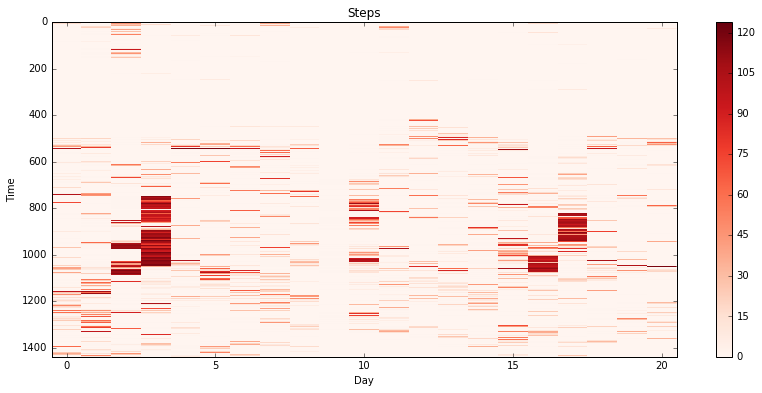

(<matplotlib.figure.Figure at 0x9e6bf8128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x9e89792e8>)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def adm(data_df, title_label, show=True):
    '''
    data_df is a data frame with a DateTimeIndex and columns representing days
    title_label is a string to put at the top of the plot
    show is a flag to denote whether or not to show the plots
    '''
    fig, ax = plt.subplots()
    # choose a color map from here: https://matplotlib.org/examples/color/colormaps_reference.html
    cmap = plt.get_cmap("Reds")
    im = plt.imshow(data_df, interpolation='none', aspect='auto', cmap=cmap)
    plt.colorbar(im)
    plt.xlabel("Day")
    plt.ylabel("Time")
    plt.title(title_label)
    fig.set_size_inches(14, 6)
    if show:
        plt.show()
    return fig, ax # for adding labels and grid lines later
    
adm(steps_df, "Steps")    

Cool! It only took a few lines of code to build a rudimentary ADM.

### Part 2: Beautifying the Plot
There are few things missing on this ADM though that would be quite nice to have:
1. X axis labels for each *date* instead of the day number in the sequence. This will help give context for the data (e.g. what season? are the days contiguous?).
    1. X axis labels for each *day of the week* in addition to the date. This will provide even more context for the data (e.g. a weekday vs. a weekend?).
    1. Vertical grid lines to divide the heat map according to the date labels.
1. Y axis labels for each *hour of the day* instead of the minute number in the index. This will help ADM readers quickly see where key hours of the day are, like noon or what time the Fitbit wearer wakes up.
    1. Horizontal grid lines to divide the heat map according to the hour labels.
    
In the next lesson, we are going to beautify our initial ADM by adding these features.